<a href="https://colab.research.google.com/github/gbcarneiro/modelo-classificacao-de-imagens/blob/main/20240526_Gerador_de_Sequ%C3%AAncia_Imagens_(Otimiza%C3%A7%C3%A3o_de_modelo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementando técnicas de otimização de modelos

O código abaixo implementa 3 técnicas de otimização de modelos, trabalhados em sala de aula. O modelo base foi o mesmo implementado na atividade ponderada da semana 4.

## Técnicas Implementadas

### 1. Data Augmentation
Data Augmentation é uma técnica usada para aumentar a quantidade e a diversidade dos dados de treinamento ao aplicar transformações aleatórias, mas realistas, às imagens originais. Este processo ajuda o modelo a generalizar melhor e a ser mais robusto a variações nos dados. No código, usamos o `ImageDataGenerator` do Keras para aplicar as seguintes transformações:
- **Rotação:** Girar a imagem em um ângulo aleatório.
- **Zoom:** Ampliar ou reduzir a imagem.
- **Deslocamento:** Mover a imagem horizontal e verticalmente.
- **Espelhamento Horizontal:** Inverter a imagem horizontalmente.

Estas transformações aumentam o conjunto de dados de treinamento, criando novas imagens a partir das originais, o que melhora a capacidade do modelo de aprender e generalizar.

### 2. Dropout
Dropout é uma técnica de regularização que ajuda a prevenir overfitting em redes neurais. Durante o treinamento, alguns neurônios são aleatoriamente "desligados" (ou seja, seu valor é ajustado para zero) em cada iteração. Isso força a rede a não depender de neurônios específicos, tornando-a mais robusta. No código, o Dropout é aplicado após as camadas de pooling e antes da camada densa final. As taxas de Dropout utilizadas são:
- **0.25:** Após as camadas de pooling.
- **0.5:** Antes da camada densa final.

### 3. Early Stopping
Early Stopping é uma técnica usada para interromper o treinamento do modelo assim que o desempenho no conjunto de validação para de melhorar. Isso ajuda a evitar o overfitting, garantindo que o modelo não continue aprendendo padrões específicos dos dados de treinamento que não generalizam bem para dados novos. No código, utilizamos a função `EarlyStopping` do Keras, monitorando a perda de validação (`val_loss`) e configurando uma paciência de 5 épocas. Se o desempenho não melhorar após 5 épocas consecutivas, o treinamento é interrompido e os melhores pesos do modelo são restaurados.

Estas técnicas foram implementadas para melhorar a performance e a robustez do modelo de rede neural convolucional, garantindo que ele não apenas performe bem nos dados de treinamento, mas também generalize adequadamente para novos dados.


In [2]:
from keras.utils import to_categorical, Sequence
from glob import glob
import cv2  # Importando cv2 para redimensionamento
from google.colab import drive
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Monta o Google Drive para acessar as imagens
drive.mount('/content/drive')

# Função para importar e pré-processar imagens
def importa_imagem(caminho):
    # Lê a imagem, redimensiona para 100x100, normaliza (dividindo por 255)
    imagem = cv2.imread(caminho)
    imagem = cv2.resize(imagem, (100, 100))  # Redimensiona a imagem
    categoria = int(caminho.split('/')[-2]) # Assume que o nome da pasta é a categoria
    return (imagem / 255.0, to_categorical(categoria, 14)) # 14 categorias possíveis

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Classe que gera lotes de dados para treinamento
class GeradorSequencias(Sequence):
    def __init__(self, entradas, batch_size):
        self.entradas = entradas
        self.batch_size = batch_size

    def __len__(self):
        # Retorna o número de lotes por época
        return np.ceil(len(self.entradas) / self.batch_size).astype(int)

    def __getitem__(self, id):
        # Gera um lote de dados
        esquerda = id * self.batch_size
        direita = min(esquerda + self.batch_size, len(self.entradas))
        batch_entradas = self.entradas[esquerda:direita]

        # Carrega e processa as imagens e categorias
        x = np.array([importa_imagem(caminho)[0] for caminho in batch_entradas])
        y = np.array([importa_imagem(caminho)[1] for caminho in batch_entradas])

        # Aplica data augmentation
        for i in range(len(x)):
            x[i] = datagen.random_transform(x[i])

        return x, y

# Caminhos para as imagens
caminhos = glob('/content/drive/MyDrive/imagens/*/*.jpg')
np.random.shuffle(caminhos)

sequencia = GeradorSequencias(caminhos, 5)

x_lote, y_lote = sequencia.__getitem__(0)
print("Shape das imagens de entrada no lote:", x_lote.shape)
print("Shape das categorias no lote:", y_lote.shape)

Mounted at /content/drive
Shape das imagens de entrada no lote: (5, 100, 100, 3)
Shape das categorias no lote: (5, 14)


In [4]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Definição do modelo de rede neural convolucional
def criar_modelo():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),  # Supondo imagens de 100x100
        MaxPooling2D(2, 2),
        Dropout(0.25),  # Dropout adicional
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),  # Dropout adicional
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(14, activation='softmax')  # 14 categorias
    ])
    return model


In [5]:
with tf.device('/gpu:0'):
  # Cria o modelo
  modelo = criar_modelo()

  # Compila o modelo
  modelo.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Verifica a arquitetura do modelo
  modelo.summary()

  # Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Treinamento do modelo
  historico = modelo.fit(sequencia, epochs=50, verbose=1, callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 64)        0

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
280/280 [==============================] - ETA: 0s - loss: 2.2326 - accuracy: 0.2136

280/280 [==============================] - 390s 1s/step - loss: 2.2326 - accuracy: 0.2136
Epoch 2/50
280/280 [==============================] - ETA: 0s - loss: 1.1987 - accuracy: 0.5714

280/280 [==============================] - 123s 438ms/step - loss: 1.1987 - accuracy: 0.5714
Epoch 3/50
280/280 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.7393

280/280 [==============================] - 111s 395ms/step - loss: 0.7398 - accuracy: 0.7393
Epoch 4/50
280/280 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.8114

280/280 [==============================] - 110s 392ms/step - loss: 0.5413 - accuracy: 0.8114
Epoch 5/50
280/280 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8393

280/280 [==============================] - 137s 488ms/step - loss: 0.4581 - accuracy: 0.8393
Epoch 6/50
280/280 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8636

280/280 [==============================] - 121s 430ms/step - loss: 0.3875 - accuracy: 0.8636
Epoch 7/50
280/280 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8764

280/280 [==============================] - 127s 453ms/step - loss: 0.3658 - accuracy: 0.8764
Epoch 8/50
280/280 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8886

280/280 [==============================] - 126s 451ms/step - loss: 0.3230 - accuracy: 0.8886
Epoch 9/50
280/280 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8936

280/280 [==============================] - 130s 463ms/step - loss: 0.3104 - accuracy: 0.8936
Epoch 10/50
280/280 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9129

280/280 [==============================] - 120s 430ms/step - loss: 0.2566 - accuracy: 0.9129
Epoch 11/50
280/280 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9171

280/280 [==============================] - 122s 435ms/step - loss: 0.2308 - accuracy: 0.9171
Epoch 12/50
280/280 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9136

280/280 [==============================] - 123s 441ms/step - loss: 0.2767 - accuracy: 0.9136
Epoch 13/50
280/280 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9550

280/280 [==============================] - 128s 457ms/step - loss: 0.1526 - accuracy: 0.9550
Epoch 14/50
280/280 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9229

280/280 [==============================] - 132s 472ms/step - loss: 0.2455 - accuracy: 0.9229
Epoch 15/50
280/280 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9343

280/280 [==============================] - 127s 452ms/step - loss: 0.2095 - accuracy: 0.9343
Epoch 16/50
280/280 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9286

280/280 [==============================] - 128s 456ms/step - loss: 0.2099 - accuracy: 0.9286
Epoch 17/50
280/280 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9357

280/280 [==============================] - 123s 440ms/step - loss: 0.2038 - accuracy: 0.9357
Epoch 18/50
280/280 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9493

280/280 [==============================] - 133s 475ms/step - loss: 0.1540 - accuracy: 0.9493
Epoch 19/50
280/280 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9293

280/280 [==============================] - 126s 449ms/step - loss: 0.2161 - accuracy: 0.9293
Epoch 20/50
280/280 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9450

280/280 [==============================] - 124s 442ms/step - loss: 0.1542 - accuracy: 0.9450
Epoch 21/50
280/280 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9093

280/280 [==============================] - 124s 440ms/step - loss: 0.2595 - accuracy: 0.9093
Epoch 22/50
280/280 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9371

280/280 [==============================] - 125s 447ms/step - loss: 0.1719 - accuracy: 0.9371
Epoch 23/50
280/280 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9593

280/280 [==============================] - 132s 471ms/step - loss: 0.1039 - accuracy: 0.9593
Epoch 24/50
280/280 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9500

280/280 [==============================] - 121s 431ms/step - loss: 0.1393 - accuracy: 0.9500
Epoch 25/50
280/280 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9443

280/280 [==============================] - 123s 439ms/step - loss: 0.1661 - accuracy: 0.9443
Epoch 26/50
280/280 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9600

280/280 [==============================] - 130s 462ms/step - loss: 0.1331 - accuracy: 0.9600
Epoch 27/50
280/280 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9286

280/280 [==============================] - 134s 479ms/step - loss: 0.2095 - accuracy: 0.9286
Epoch 28/50
280/280 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9521

280/280 [==============================] - 123s 438ms/step - loss: 0.1472 - accuracy: 0.9521
Epoch 29/50
280/280 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9486

280/280 [==============================] - 123s 437ms/step - loss: 0.1540 - accuracy: 0.9486
Epoch 30/50
280/280 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9657

280/280 [==============================] - 124s 441ms/step - loss: 0.0865 - accuracy: 0.9657
Epoch 31/50
280/280 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9457

280/280 [==============================] - 126s 451ms/step - loss: 0.2107 - accuracy: 0.9457
Epoch 32/50
280/280 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9521

280/280 [==============================] - 130s 464ms/step - loss: 0.1390 - accuracy: 0.9521
Epoch 33/50
280/280 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9593

280/280 [==============================] - 125s 447ms/step - loss: 0.1262 - accuracy: 0.9593
Epoch 34/50
280/280 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9707

280/280 [==============================] - 121s 432ms/step - loss: 0.1032 - accuracy: 0.9707
Epoch 35/50
280/280 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9843

280/280 [==============================] - 121s 433ms/step - loss: 0.0541 - accuracy: 0.9843
Epoch 36/50
280/280 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9650

280/280 [==============================] - 126s 449ms/step - loss: 0.1080 - accuracy: 0.9650
Epoch 37/50
280/280 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9529

280/280 [==============================] - 124s 442ms/step - loss: 0.1552 - accuracy: 0.9529
Epoch 38/50
280/280 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9400

280/280 [==============================] - 124s 440ms/step - loss: 0.2095 - accuracy: 0.9400
Epoch 39/50
280/280 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9550

280/280 [==============================] - 126s 448ms/step - loss: 0.1341 - accuracy: 0.9550
Epoch 40/50
280/280 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9693

280/280 [==============================] - 120s 429ms/step - loss: 0.1098 - accuracy: 0.9693
Epoch 41/50
280/280 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9786

280/280 [==============================] - 125s 447ms/step - loss: 0.0712 - accuracy: 0.9786
Epoch 42/50
280/280 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9557

280/280 [==============================] - 124s 443ms/step - loss: 0.1324 - accuracy: 0.9557
Epoch 43/50
280/280 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9714

280/280 [==============================] - 122s 434ms/step - loss: 0.0945 - accuracy: 0.9714
Epoch 44/50
280/280 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9721

280/280 [==============================] - 123s 440ms/step - loss: 0.1035 - accuracy: 0.9721
Epoch 45/50
280/280 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9843

280/280 [==============================] - 123s 439ms/step - loss: 0.0571 - accuracy: 0.9843
Epoch 46/50
280/280 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9671

280/280 [==============================] - 122s 436ms/step - loss: 0.1327 - accuracy: 0.9671
Epoch 47/50
280/280 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9379

280/280 [==============================] - 118s 422ms/step - loss: 0.1980 - accuracy: 0.9379
Epoch 48/50
280/280 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9607

280/280 [==============================] - 125s 446ms/step - loss: 0.1404 - accuracy: 0.9607
Epoch 49/50
280/280 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9743

280/280 [==============================] - 129s 459ms/step - loss: 0.0650 - accuracy: 0.9743
Epoch 50/50
280/280 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9693

280/280 [==============================] - 124s 443ms/step - loss: 0.1050 - accuracy: 0.9693


In [6]:
import matplotlib.pyplot as plt

def plotar_historico(historico):
  # Plota a perda e a acurácia para os conjuntos de treinamento e validação
  plt.figure(figsize=(12, 5))

  # Gráfico de perda
  plt.subplot(1, 2, 1)
  plt.plot(historico.history['loss'], label='Perda no treinamento')
  if 'val_loss' in historico.history:
      plt.plot(historico.history['val_loss'], label='Perda na validação')
  plt.title('Perda do Modelo')
  plt.xlabel('Épocas')
  plt.ylabel('Perda')
  plt.legend()

  # Gráfico de acurácia
  plt.subplot(1, 2, 2)
  plt.plot(historico.history['accuracy'], label='Acurácia no treinamento')
  if 'val_accuracy' in historico.history:
      plt.plot(historico.history['val_accuracy'], label='Acurácia na validação')
  plt.title('Acurácia do Modelo')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend()

  plt.tight_layout()
  plt.show()


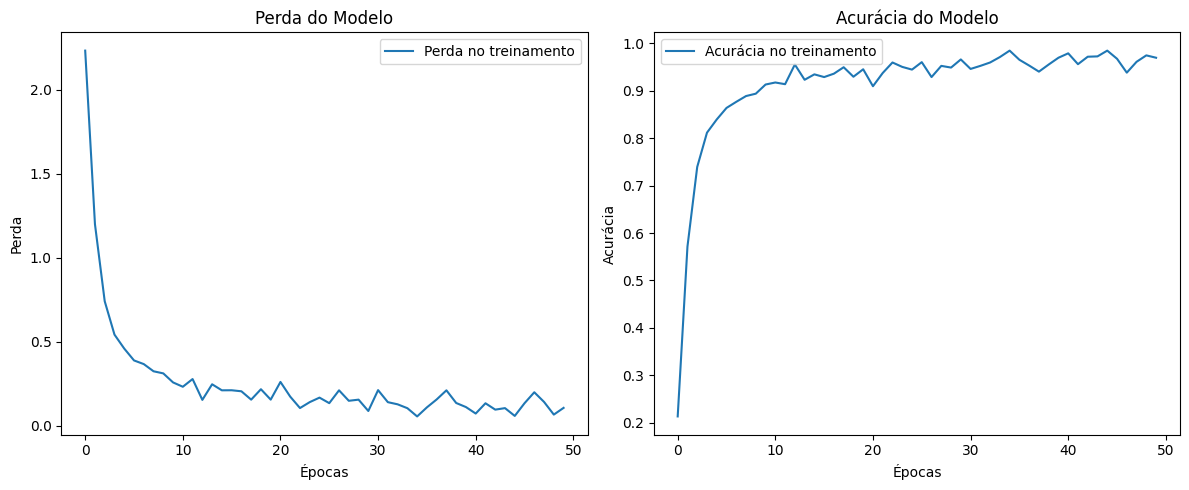

In [7]:
plotar_historico(historico)